## Importer les donnees

In [35]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

### Data Processing

In [39]:
data=[]

with open("./train.txt","r") as file:
    for line in file:
        metadata,tweet=line[1:13],line[14:]
        # Supprimer @
        tweet = tweet.replace("@"," ")
        ID,label,company = metadata.split(",")
        data.append((ID,label,company,tweet))

df=pd.DataFrame(data,columns=["id","label","company","tweet"])
df.head(10)

,id,label,company,tweet
0,0000,neu,apl,20 min line apple store short pump.\n
1,0001,irr,msf,Nueva tecnología convierte cualquier superfic...
2,0002,neu,ggl,Some people should not post replies in #Googl...
3,0003,neg,apl,I know a few others having same issue RT Joe...
4,0004,neg,msf,"#Microsoft - We put the """"backwards"""" into ba..."
5,0005,neg,twt,#twitter is sooo trash ritenow with all dezz ...
6,0006,neu,apl,RT jesperordrup: Hi apple. Household has 4 ...
7,0007,irr,msf,#ALG Culminando formación en #Microsoft M-277...
8,0008,neu,msf,#Microsoft Community Blogs The 7/365 Review -...
9,0009,irr,twt,Buenas noches a todos #Twitter off\n


In [40]:
print(df.groupby('label')['label'].count())

label
irr    1389
neg     486
neu    1871
pos     427
Name: label, dtype: int64


In [41]:
df.to_csv(r'./train.csv', index = False)

In [42]:
apl = df[df['company']=='apl']
twt = df[df['company']=='twt']
msf = df[df['company']=='msf']
ggl = df[df['company']=='ggl']

In [43]:
df['length']=df['tweet'].apply(lambda x:len(x))
len_df = df.groupby('length').count()
sent_length = len_df.index.tolist()
sent_freq = len_df['label'].tolist()

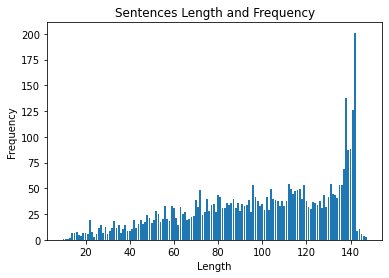

In [44]:
plt.bar(sent_length, sent_freq)
plt.title("Sentences Length and Frequency")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

## Data Processing

Pour les @ et # on va supprimer ?

## Modele LSTM

In [21]:
import pickle
from keras.utils import np_utils, plot_model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
labels = list(df['label'].unique())
vocabulary = list(df['tweet'].unique())

In [23]:
def load_data(filepath, input_shape=20):
    df = pd.read_csv(filepath)

    # 标签及词汇表
    labels, vocabulary = list(df['label'].unique()), list(df['tweet'].unique())

    # 构造字符级别的特征
    string = ''
    for word in vocabulary:
        string += word

    vocabulary = set(string)

    # 字典列表
    word_dictionary = {word: i+1 for i, word in enumerate(vocabulary)}
    with open('word_dict.pk', 'wb') as f:
        pickle.dump(word_dictionary, f)
    inverse_word_dictionary = {i+1: word for i, word in enumerate(vocabulary)}
    label_dictionary = {label: i for i, label in enumerate(labels)}
    with open('label_dict.pk', 'wb') as f:
        pickle.dump(label_dictionary, f)
    output_dictionary = {i: labels for i, labels in enumerate(labels)}

    vocab_size = len(word_dictionary.keys()) # 词汇表大小
    label_size = len(label_dictionary.keys()) # 标签类别数量

    # 序列填充，按input_shape填充，长度不足的按0补充
    x = [[word_dictionary[word] for word in sent] for sent in df['tweet']]
    x = pad_sequences(maxlen=input_shape, sequences=x, padding='post', value=0)
    y = [[label_dictionary[sent]] for sent in df['label']]
    y = [np_utils.to_categorical(label, num_classes=label_size) for label in y]
    y = np.array([list(_[0]) for _ in y])

    return x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary

In [24]:
def create_LSTM(n_units, input_shape, output_dim, filepath):
    x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary = load_data(filepath)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim,
                        input_length=input_shape, mask_zero=True))
    model.add(LSTM(n_units, input_shape=(x.shape[0], x.shape[1])))
    model.add(Dropout(0.2))
    model.add(Dense(label_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    plot_model(model, to_file='./model_lstm.png', show_shapes=True)
    model.summary()

    return model

In [28]:
def model_train(input_shape, filepath, model_save_path):

    # Train et test
    # input_shape = 100
    x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary = load_data(filepath, input_shape)
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1, random_state = 42)

    n_units = 100
    batch_size = 32
    epochs = 5
    output_dim = 20

    # Train
    lstm_model = create_LSTM(n_units, input_shape, output_dim, filepath)
    lstm_model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Save model
    lstm_model.save(model_save_path)

    N = test_x.shape[0]  # Test
    predict = []
    label = []
    for start, end in zip(range(0, N, 1), range(1, N+1, 1)):
        sentence = [inverse_word_dictionary[i] for i in test_x[start] if i != 0]
        y_predict = lstm_model.predict(test_x[start:end])
        label_predict = output_dictionary[np.argmax(y_predict[0])]
        label_true = output_dictionary[np.argmax(test_y[start:end])]
        print(''.join(sentence), label_true, label_predict) # Resultat
        predict.append(label_predict)
        label.append(label_true)

    acc = accuracy_score(predict, label) # Accuracy
    print('Accuracy: %s.' % acc)

In [26]:
model_save_path = './test.h5'
input_shape = 180
filepath = './train.csv'

In [27]:
model_train(input_shape, filepath, model_save_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 20)           14760     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               48400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 63,564
Trainable params: 63,564
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
118/118 [==============================] - 14s 121ms/step - loss: 1.2327 - accuracy: 0.4423
Epoch 2/5
118/118 [==============================] - 15s 124ms/step - loss: 1.1689 - accuracy: 0.4338
Epoch 3/5
118/118 [===========================

 #Google #IceCreamSandwich Debuts as IPhone Sets Record: Tech. http://t.co/TrENUYF4
 neu neu
 Como puedo checar mi correo si tengo cuenta @apple.com?? :S osea no q onda con eso!! jajaja
 irr irr
 #samsung и #google представили новый смартфон galaxy nexus #autofollow
 irr irr
 #Android #Google Need Proof of Verizon’s Galaxy Nexus? http://t.co/jcP7bkvg #DhilipSiva
 neu irr
 @AleeRetana cambiale el fondo a este tu coso vos!! XD esta aburriiiidooo.. x) aaa por cierto... WOW! ya no te abruma el #twitter x) #Welcome
 irr irr
 #Twitter Buzz Builds for the Occupy Wall Street Movement [CHARTS] #SocialMedia #SMM http://t.co/X55u6i4w
 neu neu
 #twitter #detik Tak Ada Api di TransJ yang Meledak di SPBG Pinang Ranti http://t.co/OTIJLXp7
 irr neu
 #Termine am 20. Oktober ++ #ADVA, #Nokia und #Microsoft öffnen ihre Bücher http://t.co/aoZoNUKf
 irr irr
 Microsoft opens the spigot, Windows Phone Mango available to all #microsoft #windowsphone http://t.co/GbKV9pbQ #microsoft
 neu neu
 Wow! RT @dalmaer: 

 I don't see the point of following a news station on #twitter if there's breaking news people are gunna tweet about it anyway #obvs
 neu neu
 Just participated in another #Microsoft #SQLServer certification test with #TSQL typing instead of multiple choices. Really cool.
 pos neu
 SO IT'S BEEN A LOOONG MINUTE BUT #TWITTER, IM BACK & WITH A CLOTHING LINE! #SWAGG
 neu neu
 Ahora no sé por qué me alejé de #Twitter!! Dv8
 irr irr
 #twitter is trippin
 neu neu
 @RAD_Software Yes good points about #ERP but unfair assessment in saying ""#SAGE, #SAP and #Microsoft Dynamics, are not delivering""
 pos neu
 .@apple thanks for fixing this... http://t.co/wTj1ogDO
 pos neu
 Saino Aki #Twitter
 irr neu
 coming back soon!!!! #twitter...
 neu neu
 RT @pimentacom: #CPqD e #Microsoft testam opção para banda larga. Leia matéria que foi destaque no Brasil Econômico: http://t.co/wImxVTlB
 irr irr
 #Microsoft news: #SQLServer licensing will be different from december2011 | #Office365 and #Azure will be avai

 If #Microsoft earnings disappoint, blame consumer PC sales http://t.co/xEKwTlUg
 neu neu
 Sistema de fotos panorâmicas na camera do icecream sandwich #icecreamsandwich #galaxynexus #google #samsung
 irr irr
 probando la videollamada en facebook......buenooooo en esto si le ganaron a #Twitter........
 irr irr
 Foto nova aqui no #Twitter. Essa ficou melhor.... rs #Adoro esse blazer. Preciso comprar um... #CTX arrazando nas roupas que eu visto no pgm
 irr irr
 WOW DOGS!! @Apple w/Starr earlier - upstairs in the huge soho store and all of a sudden she sprung to attention... http://t.co/b2PLMYVD
 neu neu
 I want everybody on earth to iMessage me. Is there anyway the world can iMessage me without giving them my phone number??? @Apple
 neu neu
 #twitter off buenas noches:$
 irr neu
 #Facebook ah quedado en el olvido gracias a #Twitter
 irr irr
 RT @Jewelz2611 @mashable @apple, iphones r 2 expensive. Most went w/ htc/galaxy. No customer loyalty w/phone comp..
 neg neu
 Now @apple won't let me

 SO Hinweis: kostenlose SEO Videos http://t.co/pwldYXVE #google
 irr neu
 RT @DominicanDroids: Cuando 2 grandes se unen, #Samsung y #Google... Estas cosas son las que pasan... #GalaxyNexus
 irr irr
 Get rid of that tangled mess behind your computer desk with this #Microsoft Wireless Mouse and Keyboard: http://t.co/n4LewRAy
 neu neu
 RT @drkhan: Are you going to #RSNA? Visit #Microsoft at booth 1411 http://t.co/wdHFz7hp #RSNA2011 #RSNA11 #radiology #Amalga #HealthVault
 neu neu
 Ever since the Mango update, my phone is chewing through its battery like nobody's business... Coincidence or real issue? #WP7 #Microsoft
 neg neu
 Causando na loja da @apple
 irr irr
 Zeer enthousiaste reacties op bedrijfsbezoek aan #Microsoft voor de (interim) #secretaresse, dank Kelly en Brigitte voor de goede ontvangst!
 irr irr
 Microsoft Security Essentialの定義ファイルがアップデートしました：1.115.68.0 &gt; http://t.co/lZde20Vy #Microsoft
 irr irr
 Video: SIRI also gets angry. http://t.co/Ku288WX6 @chrisvoss @apple #apple #

 Check out our newly revamped Testimonials page for more information on how #Microsoft #Dynamics #CRM can work fo... http://t.co/nnvy8NP2
 neu neu
 WOW that #AmberCole video hit #Google!! I'm done haha.....
 neu neu
 so #twitter who wants to buy me #lunch?
 neu neu
 People on #Twitter n #Facebook all day, wat are you really doin wit yo life....#ImJusAskin
 neu neu
 (High-tech)- Demain sur LNT: ""#Microsoft s'implique dans le développement socioéconomique"" par @Joumany #twitoma #IT #blogoma
 irr irr
 #Android: This Is the #Samsung Galaxy Nexus, #Google's New Official Android Phone(via @Gizmodo) - The... http://t.co/wS4GS9uk
 neu neu
 #SMAU Milano & #I9 domani un posto in prima fila!Vi aspetto 11:30 area sessioni tecniche #Microsoft stay tunef!
 irr irr
 the nice guy at the @apple store replaced my phone gratis when I showed him the hairline crack on the screen. thanks @apple
 pos neu
 ツイッターを利用して感謝の気持ちとともに約２０００円が振り込まれ続ける方法→ｺｺ→ http://t.co/TyjUGsnQ ←ｺｺ← :) #ビジネス #稼ぐ #副業 #Twitter #ツイッター
 